Dual Annealing Global Optimisation
==================================

Knowledge:
- https://machinelearningmastery.com/dual-annealing-optimization-with-python/

Basic example with rosenbrock
-----------------------------

In [19]:
from scipy.optimize import rosen, dual_annealing
bounds = [(0,2), (0, 2)]
result = dual_annealing(rosen, bounds)
result.x, result.fun


(array([ 0.99999724,  0.9999944 ]), 8.1696741194487742e-12)

In [22]:
import sys
sys.path.insert(0, '../')
import random

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from scipy.optimize import dual_annealing, Bounds
from scipy.interpolate import interp1d

from silentsub.device import StimulationDevice
from silentsub.CIE import get_CIES026

sns.set_context('notebook')
sns.set_style('whitegrid')

Load the data with `StimulationDevice`
--------------------------------------

In [5]:
spds = pd.read_csv('../data/S2_corrected_oo_spectra.csv', index_col=['led','intensity'])
spds.index.rename(['Primary', 'Setting'], inplace=True)
spds.columns = pd.Int64Index(spds.columns.astype(int))

# list of colors for the primaries
colors = ['blueviolet', 'royalblue', 'darkblue', 'blue', 'cyan', 
          'green', 'lime', 'orange', 'red', 'darkred']

# instantiate the class
device = StimulationDevice(
    resolutions=[4095]*10,
    colors=colors,
    spds=spds,
    spd_binwidth=1)

Define optimisation problem
---------------------------

This is the 'basic' optimisation where we aim to maximise melanopic contrast whilst keeping cone contrast at zero.

In [14]:
class OptimisationProblem:
    def __init__(self, aopic):
        self.aopic = aopic

    def smlri_calculator(self, weights):
        '''Calculates a-opic irradiance for the given weights.
        The first 10 values in weights define the background
        spectrum and the second 10 values define the modulation'''
        background = weights[0:10]
        modulation = weights[10:20]
        bg_smlri = 0
        mod_smlri = 0
        for led in range(10):
            x = self.aopic.loc[led].index / 4095
            y = self.aopic.loc[led]
            f = interp1d(x, y, axis=0, fill_value='extrapolate')
            bg_smlri += f(background[led])
            mod_smlri += f(modulation[led])
        return (pd.Series(bg_smlri, index=self.aopic.columns, name='Background'),
                pd.Series(mod_smlri, index=self.aopic.columns, name='Modulation'))

    def objective_function(self, weights):
        '''Calculates negative melanopsin contrast for background
        and modulation spectra. We want to minimise this.'''
        bg_smlri, mod_smlri = self.smlri_calculator(weights)
        contrast = (mod_smlri.I-bg_smlri.I) / bg_smlri.I
        return -contrast

    def cone_contrast_constraint_function(self, weights):
        '''Calculates S-, M-, and L-opic contrast for background
        and modulation spectra. We want to this to be zero'''
        bg_smlri, mod_smlri = self.smlri_calculator(weights)
        contrast = np.array([(mod_smlri.S-bg_smlri.S) / bg_smlri.S,
                             (mod_smlri.M-bg_smlri.M) / bg_smlri.M,
                             (mod_smlri.L-bg_smlri.L) / bg_smlri.L])
        return contrast

    def weights_to_settings(self, weights):
        '''Turns weights to 12-bit STLAB settings.'''
        return ([int(val*4095) for val in res.x[0:10]],
                [int(val*4095) for val in res.x[10:20]])



Do optimisation
---------------

Note -- this had a promising start but appeared to get stuck so I interrupted the program. Changing the parameters could be helpful...

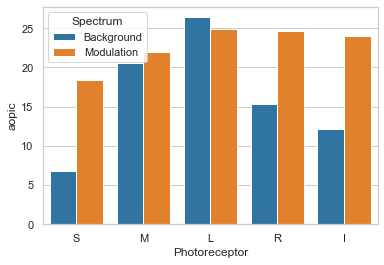

[ 0.59764393  0.18634392  0.09328148  0.14980742  0.18130395  0.22043483
  0.76402969  0.51770829  0.24786106  0.14845294  0.72462009  0.67493443
  0.97025378  0.70720536  0.08948404  0.83257024  0.36363052  0.46537071
  0.62535727  0.11757798] -0.967252557506 0


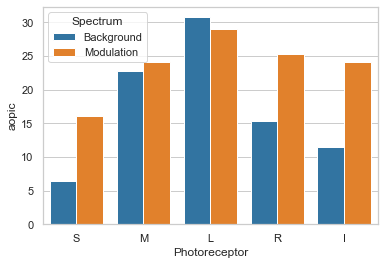

[ 0.88197513  0.09968171  0.00661926  0.06314521  0.09464173  0.50476603
  0.67736747  0.8020395   0.16119884  0.43278414  0.00895129  0.95926563
  0.88359156  0.62054314  0.37381524  0.74590802  0.2769683   0.74970192
  0.90968847  0.03091577] -1.10488970208 0


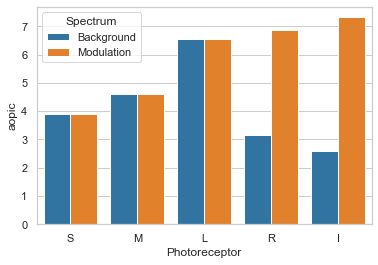

[  7.84536788e-01   9.49660803e-14   1.40268512e-13   2.73927736e-14
   2.43087994e-14   4.56306097e-03   1.58730159e-01   2.35255740e-01
   4.76616671e-03   5.11531224e-03   1.96931002e-11   1.26579298e-12
   1.17542616e-01   4.91549422e-01   2.66295223e-01   1.43687132e-02
   1.22833100e-02   1.48645090e-02   9.85667927e-01   9.97644284e-01] -1.81915468445 1


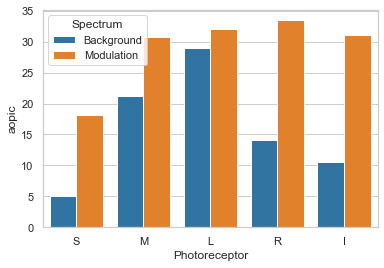

[ 0.33473533  0.22989205  0.03568769  0.07255758  0.10098568  0.21687098
  0.82238768  0.60436664  0.41565361  0.42675632  0.77640876  0.32400769
  0.97259173  0.99994245  0.57175078  0.83514513  0.92433098  0.19356893
  0.39315525  0.53154815] -1.97210385991 0


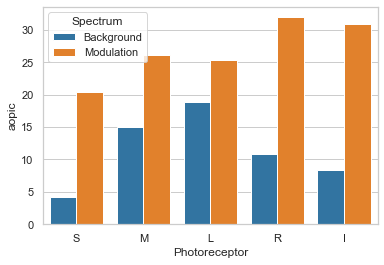

[ 0.09751438  0.2215805   0.17058778  0.01238092  0.02381915  0.17484208
  0.72136364  0.24078483  0.14866754  0.2670989   0.7110837   0.79086959
  0.88705661  0.96955852  0.49005449  0.99774784  0.59478939  0.08073162
  0.4205499   0.45028304] -2.70306707244 0


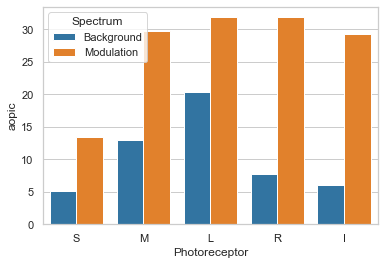

[ 0.33904209  0.2215805   0.15042201  0.01238092  0.02381915  0.17484208
  0.2020318   0.85433436  0.05429292  0.42717986  0.14185844  0.2914962
  0.63432004  0.96955852  0.96296273  0.92481965  0.59478939  0.37796769
  0.43793689  0.82973254] -3.81064913785 0


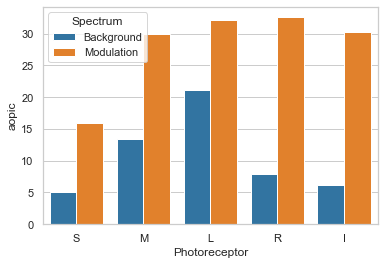

[ 0.33904209  0.2215805   0.15042201  0.01238092  0.02381915  0.17484208
  0.2020318   0.88077553  0.3707266   0.14305513  0.67028171  0.2914962
  0.63432004  0.96955852  0.96296273  0.92481965  0.59478939  0.37796769
  0.43793689  0.82973254] -3.93860968408 0


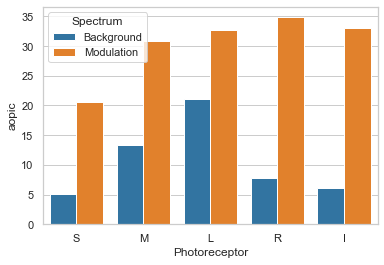

[ 0.33904209  0.2215805   0.15042201  0.01238092  0.02381915  0.17484208
  0.2020318   0.88077553  0.3707266   0.14305513  0.67028171  0.98774964
  0.63432004  0.96955852  0.96296273  0.92481965  0.59478939  0.37796769
  0.43793689  0.82973254] -4.39105215506 0


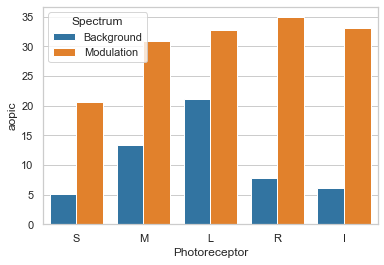

[ 0.33904209  0.2215805   0.15042201  0.01238092  0.02381915  0.17484208
  0.2020318   0.88077553  0.3707266   0.14305513  0.67028171  0.98774964
  0.6395799   0.96955852  0.96296273  0.92481965  0.59478939  0.37796769
  0.43793689  0.82973254] -4.3949587223 0


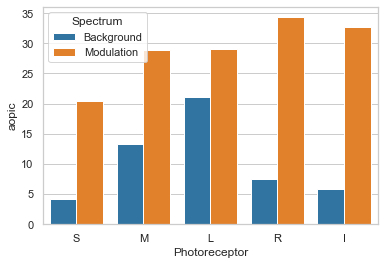

[ 0.14891819  0.2215805   0.15042201  0.01238092  0.02381915  0.17484208
  0.2020318   0.88077553  0.3707266   0.14305513  0.67028171  0.98774964
  0.6395799   0.96955852  0.96296273  0.92481965  0.59478939  0.19238381
  0.91674963  0.18869852] -4.66862666249 0


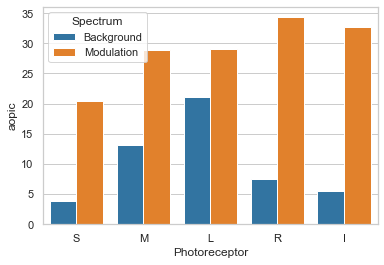

[ 0.14891819  0.16934399  0.15042201  0.01238092  0.02381915  0.17484208
  0.2020318   0.88077553  0.3707266   0.14305513  0.67028171  0.98774964
  0.6395799   0.96955852  0.96296273  0.92481965  0.59478939  0.19238381
  0.91674963  0.18869852] -4.85337932835 0


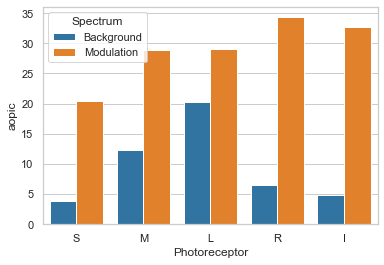

[ 0.14891819  0.16934399  0.15042201  0.01238092  0.02381915  0.06490877
  0.2020318   0.88077553  0.3707266   0.14305513  0.67028171  0.98774964
  0.6395799   0.96955852  0.96296273  0.92481965  0.59478939  0.19238381
  0.91674963  0.18869852] -5.6472921901 0


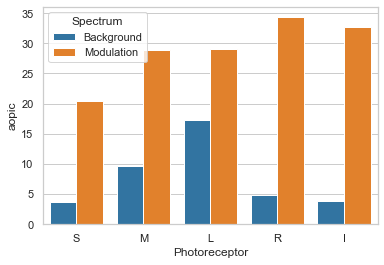

[ 0.14891819  0.16934399  0.15042201  0.01238092  0.02381915  0.06490877
  0.04437752  0.88077553  0.3707266   0.14305513  0.67028171  0.98774964
  0.6395799   0.96955852  0.96296273  0.92481965  0.59478939  0.19238381
  0.91674963  0.18869852] -7.48416156809 0


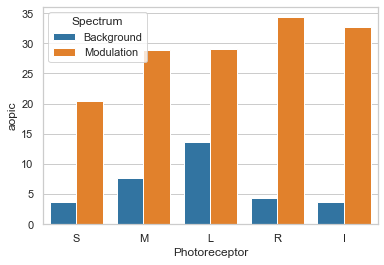

[ 0.14891819  0.16934399  0.15042201  0.01238092  0.02381915  0.06490877
  0.04437752  0.66495776  0.3707266   0.14305513  0.67028171  0.98774964
  0.6395799   0.96955852  0.96296273  0.92481965  0.59478939  0.19238381
  0.91674963  0.18869852] -8.0128414348 0


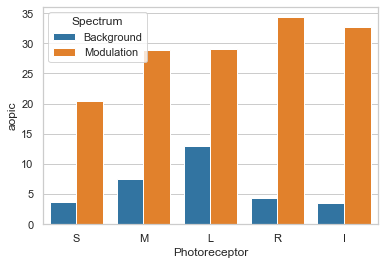

[ 0.14891819  0.16934399  0.15042201  0.01238092  0.02381915  0.06490877
  0.04437752  0.66495776  0.06075185  0.14305513  0.67028171  0.98774964
  0.6395799   0.96955852  0.96296273  0.92481965  0.59478939  0.19238381
  0.91674963  0.18869852] -8.08787217335 0


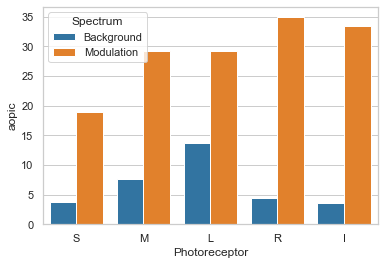

[ 0.14891819  0.16934399  0.15042201  0.01238092  0.02381915  0.06490877
  0.04437752  0.66495776  0.06075185  0.57234552  0.01107019  0.98774964
  0.96155489  0.96955852  0.96296273  0.92481965  0.59478939  0.19238381
  0.91674963  0.18869852] -8.12812812058 0


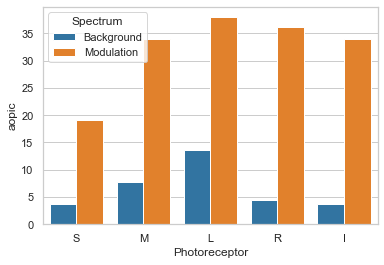

[ 0.14891819  0.16934399  0.15042201  0.01238092  0.02381915  0.06490877
  0.04437752  0.66495776  0.06075185  0.57234552  0.01107019  0.98774964
  0.96155489  0.96955852  0.96296273  0.92479583  0.59478939  0.67783572
  0.91674963  0.18869852] -8.26513638801 0


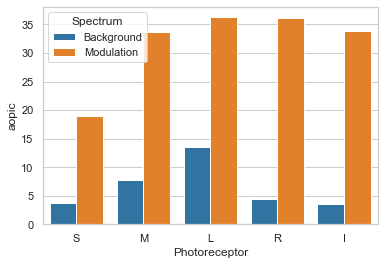

[ 0.14891819  0.16934399  0.15042201  0.01238092  0.02381915  0.06490877
  0.04437752  0.66495776  0.37967045  0.09132938  0.01107019  0.98774964
  0.96155489  0.96955852  0.96296273  0.92479583  0.59478939  0.67783572
  0.18081505  0.09229135] -8.35825260349 0


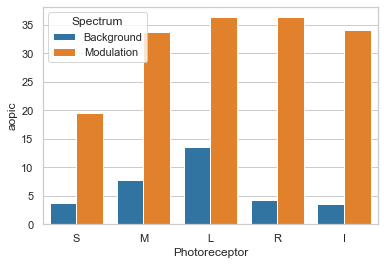

[ 0.14891819  0.16934399  0.15042201  0.01238092  0.02381915  0.06490877
  0.04437752  0.66495776  0.37967045  0.09132938  0.09171648  0.98774964
  0.96155489  0.96955852  0.96296273  0.92479583  0.59478939  0.67783572
  0.18081505  0.09229135] -8.41936643341 0


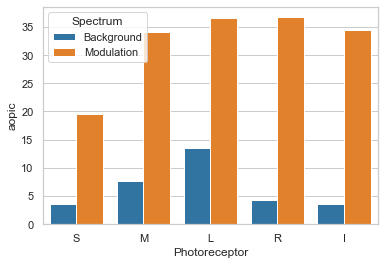

[ 0.14891819  0.16934399  0.15042201  0.01238092  0.02381915  0.06490877
  0.04437752  0.66495776  0.37967045  0.09132938  0.09171648  0.98774964
  0.96155489  0.96955852  0.96296273  0.95894531  0.59478939  0.67783572
  0.18081505  0.09229135] -8.51277283446 0


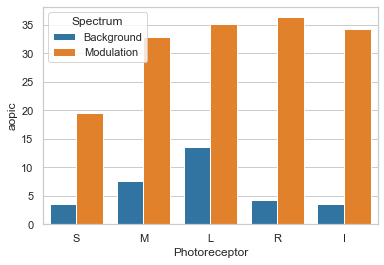

[ 0.14891819  0.14842381  0.15042201  0.01238092  0.02381915  0.06490877
  0.04437752  0.66495776  0.37967045  0.09132938  0.09171648  0.98774964
  0.96155489  0.96955852  0.96296273  0.95894531  0.59478939  0.51512506
  0.93420859  0.00590424] -8.75569193591 0


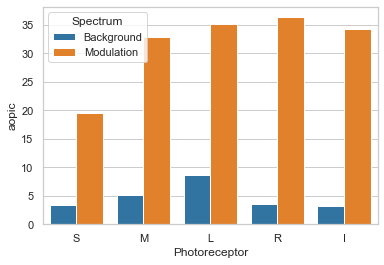

[ 0.14891819  0.14842381  0.15042201  0.01238092  0.02381915  0.06490877
  0.04437752  0.38720487  0.37967045  0.09132938  0.09171648  0.98774964
  0.96155489  0.96955852  0.96296273  0.95894531  0.59478939  0.51512506
  0.93420859  0.00590424] -9.59104956775 0


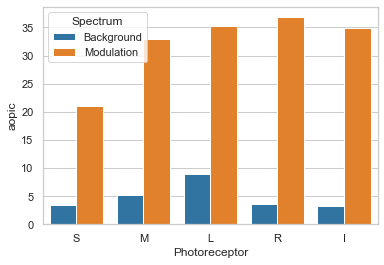

[ 0.14891819  0.14842381  0.15042201  0.01238092  0.02381915  0.06490877
  0.04437752  0.38720487  0.37967045  0.240404    0.41135754  0.98774964
  0.96155489  0.96955852  0.96296273  0.95894531  0.59478939  0.51512506
  0.93420859  0.00590424] -9.68075801764 0


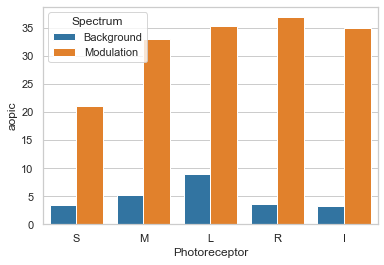

[ 0.14891819  0.14842381  0.15042201  0.01238092  0.02381915  0.06490877
  0.04437752  0.38720487  0.37967045  0.240404    0.41135754  0.98774964
  0.99799132  0.96955852  0.96296273  0.95894531  0.59478939  0.51512506
  0.93420859  0.00590424] -9.70470999268 0


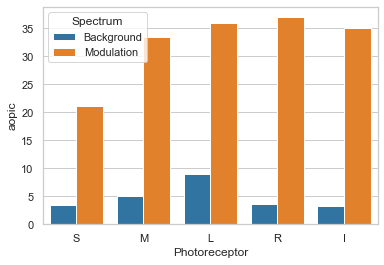

[ 0.14891819  0.14842381  0.15042201  0.01238092  0.02381915  0.06490877
  0.04437752  0.38720487  0.37967045  0.240404    0.41135754  0.98774964
  0.99799132  0.96955852  0.96296273  0.95894531  0.59478939  0.5560841
  0.93420859  0.00590424] -9.71652940712 0


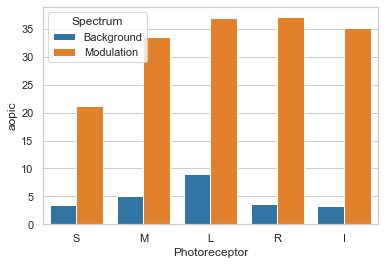

[ 0.14891819  0.14842381  0.15042201  0.01238092  0.02381915  0.06490877
  0.04437752  0.38720487  0.37967045  0.240404    0.41135754  0.98774964
  0.99799132  0.96955852  0.96296273  0.95894531  0.59478939  0.5560841
  0.53305471  0.91759288] -9.75103329477 0


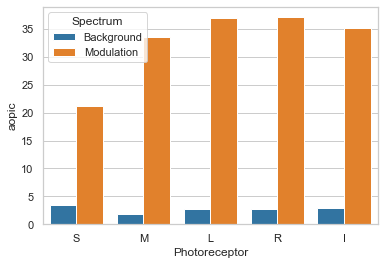

[ 0.14891819  0.14842381  0.15042201  0.01238092  0.02381915  0.06490877
  0.04437752  0.01523494  0.37967045  0.240404    0.41135754  0.98774964
  0.99799132  0.96955852  0.96296273  0.95894531  0.59478939  0.5560841
  0.53305471  0.91759288] -10.989666199 0


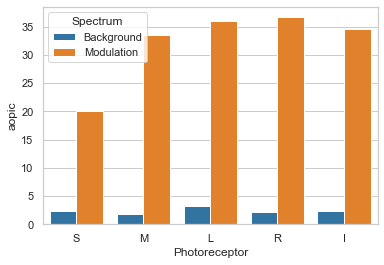

[ 0.14891819  0.03538521  0.15042201  0.01238092  0.02381915  0.06490877
  0.04437752  0.01523494  0.65203637  0.240404    0.21694522  0.98774964
  0.99799132  0.9317444   0.96296273  0.95894531  0.59478939  0.6024825
  0.13587797  0.44943772] -13.8210811899 0


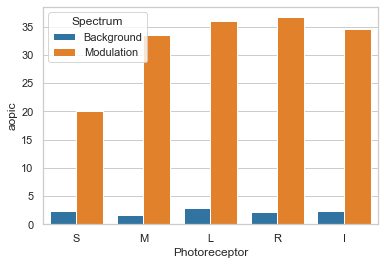

[ 0.14891819  0.03538521  0.15042201  0.01238092  0.02381915  0.06490877
  0.0461056   0.01523494  0.63456475  0.05992103  0.21694522  0.98774964
  0.99799132  0.9317444   0.96296273  0.95894531  0.59478939  0.6024825
  0.13587797  0.44943772] -13.9540763261 0


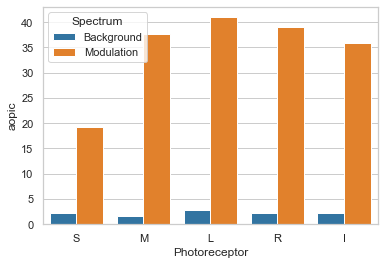

[ 0.14891819  0.03538521  0.15042201  0.01238092  0.02381915  0.06490877
  0.0461056   0.01523494  0.63456475  0.05992103  0.05189797  0.98774964
  0.99799132  0.9317444   0.96296273  0.95894531  0.89302678  0.6024825
  0.13587797  0.44943772] -14.560825095 0


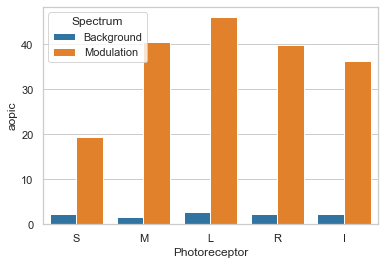

[ 0.14891819  0.03538521  0.15042201  0.01238092  0.02381915  0.06490877
  0.0461056   0.01523494  0.63456475  0.05992103  0.05189797  0.98774964
  0.99799132  0.9317444   0.96296273  0.95894531  0.89302678  0.90272317
  0.13587797  0.44943772] -14.6963715571 0


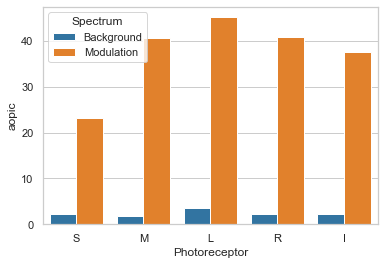

[ 0.14891819  0.03538521  0.15042201  0.01238092  0.02381915  0.06490877
  0.0461056   0.01523494  0.86646866  0.15276175  0.847643    0.98774964
  0.99799132  0.9317444   0.96296273  0.95894531  0.89302678  0.90272317
  0.00175715  0.05304569] -15.0780003367 0


KeyboardInterrupt: 

In [18]:
# A random starting point for the optimisation
x0 = np.random.rand(1, 20)[0] 

# Initialize optiisation problem
op = OptimisationProblem(device.aopic)

# Global constraints
constraints = ({
    'type': 'eq',
    'fun': lambda x: op.cone_contrast_constraint_function(x)
})

# The bounds should be between 0-1, otherwise we are outside the
# gamut of the device
bounds = [(0, 1.),] * 20

# Plotting func for call back
def plot_solution(background, modulation):
    df = (
        pd.concat([background, modulation], axis=1)
        .T.melt(
            value_name='aopic',
            var_name='Photoreceptor',
            ignore_index=False)
        .reset_index()
        .rename(
            columns={'index': 'Spectrum'})
         )
    fig = sns.barplot(data=df, x='Photoreceptor', y='aopic', hue='Spectrum')
    plt.show()
    
# Callback function to give info on all minima found 
def print_fun(x, f, context):
    bg, mod = op.smlri_calculator(x)
    plot_solution(bg, mod)
    print(x, f, context)

# Local minimizer options
minimizer_kwargs = {
    'method': 'SLSQP',
    'bounds': bounds,
    'options': {'maxiter': 100},
    'constraints': constraints
}
    
# Do the Dual Annealing optimisation with default params
res = dual_annealing(
    func=op.objective_function,
    bounds=bounds,
    args=(),
    maxiter=1000,
    local_search_options=minimizer_kwargs,
    initial_temp=5230.0,
    restart_temp_ratio=2e-05,
    visit=2.62,
    accept=-5.0,
    maxfun=10000000.0,
    seed=None,
    no_local_search=False,
    callback=print_fun,
    x0=x0
)